# SpikeInterface v0.101.2 - Adapted by Rodrigo Noseda - November 2024

SpikeInterface to analyze a multichannel dataset from Cambridge Neurotech Probes. 
The dataset is extracted using open-ephys DAQ and Bonsai-rx (in .bin).
Event_timestamps need some work.

# 0. Preparation <a class="anchor" id="preparation"></a>

In [ ]:
import spikeinterface.full as si
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import os
import glob
import warnings
warnings.simplefilter("ignore")
%matplotlib widget
print(f"SpikeInterface Version: {si.__version__}")

SpikeInterface Version: 0.101.2


# 1. Loading saved recording and probe information <a class="anchor" id="loading"></a>

In [2]:
# Setting file paths and basic parameters
base_folder = Path('D:/Ephys_C2DRG/')
data_folder = Path("D:/Ephys_C2DRG/2023_9_19/")

# parameters associated to the recording in bin format
#num_channels = 64 #must know apriori; modify in probe below accordingly.
#fs = 30000
#gain_to_uV = 0.195
#offset_to_uV = 0
#rec_dtype = "float32"
#time_axis = 0     
#time_format = "%H:%M:%S.%f"
n_cpus = os.cpu_count()
n_jobs = n_cpus #n_jobs = -1 :equal to the number of cores.
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="1s", progress_bar=True)

# Loading filtered and cleaned recording from binary saved.
#recording_filename = data_folder / 'recording_preprocessed' / 'traces_cached_seg0.raw'
#recording_loaded = si.read_binary(recording_filename, num_channels=num_channels,sampling_frequency=fs,
#                           dtype=rec_dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV, 
#                           time_axis=time_axis, is_filtered=True)

recording_loaded = si.load_extractor(data_folder / 'recording_preprocessed')

ProbeInterface version: 0.2.24


(-75.0, 320.0)

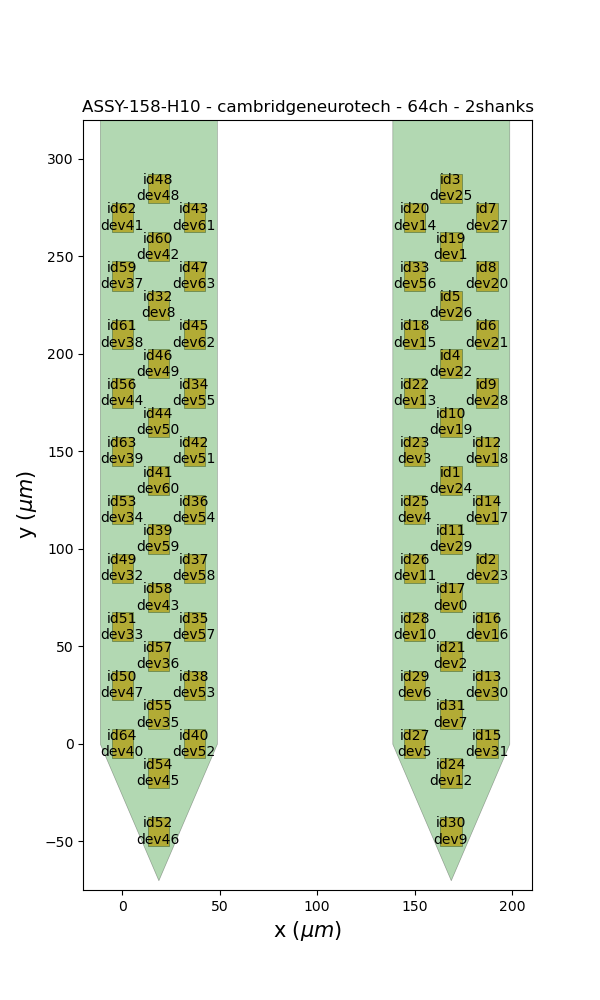

In [3]:
#Get probe from library and set channel mapping
import probeinterface as pi
from probeinterface.plotting import plot_probe
print(f"ProbeInterface version: {pi.__version__}")
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-158-H10' #probe_name = 'ASSY-158-F' #probe_name = 'ASSY-158-H6'
probeH10 = pi.get_probe(manufacturer, probe_name)#library: comes with contact_ids and shank_ids info.
#Mapping Intan (device) channels
device_channel_indices = [24,23,25,22,26,21,27,20,28,19,29,18,30,17,31,16,0,15,1,14,2,13,3,12,4,11,5,10,6,9,7,8,
    56,55,57,54,58,53,59,52,60,51,61,50,62,49,63,48,32,47,33,46,34,45,35,44,36,43,37,42,38,41,39,40] #Modify accordingly.
#   88,87,89,86,90,85,91,84,92,83,93,82,94,81,95,80,64,79,65,78,66,77,67,76,68,75,69,74,70,73,71,72,
#   120,119,121,118,122,117,123,116,124,115,125,114,126,113,127,112,96,111,97,110,98,109,99,108,100,107,101,106,102,105,103,104]
#Setting Intan channels to probe(RHD-2132/2164)
probeH10.set_device_channel_indices(device_channel_indices)
#Plotting probe
fig, ax = plt.subplots(figsize=(6, 10))
plot_probe(probeH10, ax=ax, with_contact_id=True, with_device_index=True)
ax.set_xlim(-20, 210)
ax.set_ylim(-75, 320)

In [ ]:
#Set and group by shank probe before sorting
recording_f_cmr_w_clean_prb = recording_loaded.set_probe(probeH10, group_mode="by_shank")
recordings_by_group = recording_f_cmr_w_clean_prb.split_by("group")
recording_to_process = recordings_by_group[0]

# Take a 5min time slice when testing sorter.
#recording_to_process = recording_to_process.time_slice(start_time=0, end_time=300)

In [ ]:
channel_ids = recording_to_process.get_channel_ids()

w = si.plot_traces(recording_to_process, time_range=[568, 600], channel_ids=channel_ids,
                return_scaled=True, show_channel_ids=True, backend="ipywidgets")

In [ ]:
#Get and set time vector, and confirm recording_to_process features
for i in range(recording_to_process.get_num_segments()):
    s = recording_to_process.get_num_samples(segment_index=i)
    d = recording_to_process.get_duration(segment_index=i)
    t = recording_to_process.get_times(segment_index=i)
    p = recording_to_process.has_probe()
    tms = recording_to_process.set_times(t, segment_index=i, with_warning=True)
    tv = recording_to_process.has_time_vector(segment_index=i)
    print(f"Segment {i}: Duration: {d} sec - Samples: {s} - Has time vector?: {tv} - Has Probe?: {p} - Time Vector: {t}")

# 3. Spike sorting <a class="anchor" id="spike-sorting"></a>

In [ ]:
from pprint import pprint
default_KS4_params = si.get_default_sorter_params('kilosort4')
# Parameters can be changed by single arguments: 
default_KS4_params['batch_size'] = 60000 #2 sec
default_KS4_params['nblocks'] = 0 #number of sections the probe is divided when performing drift correction (0=drift correction skipped)
default_KS4_params['Th_universal'] = 8
default_KS4_params['Th_learned'] = 7
default_KS4_params['nearest_chans'] = 10 
default_KS4_params['nearest_templates'] = 32
#default_KS4_params['artifact_threshold'] = 50
#default_KS4_params['dmin'] = 30
default_KS4_params['dminx'] = 30
#default_KS4_params['min_template_size'] = 20
#default_KS4_params['scaleproc'] = 200
default_KS4_params['do_CAR'] = False
default_KS4_params['skip_kilosort_preprocessing'] = True
default_KS4_params['do_correction'] = False
default_KS4_params['duplicate_spike_ms'] = 0.5
sorter_params = default_KS4_params
pprint(sorter_params)

In [ ]:
#Run spike sorting on recording using docker container
sorting_KS4 = si.run_sorter('kilosort4', recording_to_process, folder=data_folder / 'sorting_KS4_s0',
                            docker_image=True, verbose=True, **sorter_params)#, **job_kwargs)
print(sorting_KS4)

In [ ]:
#sorting_KS4 = si.read_kilosort(data_folder / 'sorting_KS4' / 'sorter_output')
w_rs = si.plot_rasters(sorting_KS4, time_range=(0, 600), backend='matplotlib')

# 6. Postprocessing: SortingAnalyzer <a class="anchor" id="sortinganalyzer"></a>

The core module uses `SortingAnalyzer` for postprocessing computation from paired recording-sorting objects. It retrieves waveforms, templates, spike amplitudes, etc.

In [ ]:
sparsity = si.estimate_sparsity(sorting_KS4,recording_to_process, num_spikes_for_sparsity=100, method="radius",
                               radius_um=100, peak_sign="neg", amplitude_mode="extremum")
print(sparsity)

In [ ]:
#sa = si.load_sorting_analyzer(data_folder / 'sorting_analyzer_KS4')
sa = si.create_sorting_analyzer(sorting_KS4, recording_to_process, folder=data_folder / "sorting_analyzer_KS4_s0", 
                              format="binary_folder", sparsity=sparsity, overwrite=True, **job_kwargs)

#### Computing Extensions: PCA, waveforms, templates, spike amplitude, correlograms, etc.

Let's move on to explore the postprocessing capabilities of the `postprocessing` module. Similarly to the `SortingAnalizer` object, the method 'compute` retrieve info on demand.

In [ ]:
#SortingAnalizer computations: each call will recompute and overwrite previous computations
rand = sa.compute("random_spikes", method="uniform", max_spikes_per_unit=500)#subsample to create a template
wf = sa.compute("waveforms", ms_before=1.0, ms_after=2.0, **job_kwargs)
templ =sa.compute("templates", ms_before=1.0, ms_after=2.0, operators=["average", "std"])#from raw waveforms or random_spikes
spk_amp = sa.compute("spike_amplitudes", peak_sign="neg")#based on templates
noise = sa.compute("noise_levels")
#amp_scal = sa.compute("amplitude_scalings")#per channel
pca = sa.compute("principal_components", n_components=3, mode="by_channel_local")#, whiten=False, dtype='float32')
corr = sa.compute("correlograms", window_ms=50.0, bin_ms=1.0, method="auto")
isi = sa.compute("isi_histograms", window_ms=50.0, bin_ms=1.0, method="auto")
spk_loc = sa.compute("spike_locations", ms_before=0.5, ms_after=0.5, method="center_of_mass")#method="monopolar_triangulation"(slow but more acccurate) #need for drift metrics (drift_ptp, drift_std, drift_mad)
templ_sim = sa.compute("template_similarity", method="cosine_similarity", )#need for spikeinterface_gui. Not well suited for high-density probes!
u_loc = sa.compute("unit_locations", method='center_of_mass')#method="monopolar_triangulation")
#templ_metric = sa.compute("template_metrics", include_multi_channel_metrics=True) #good when analyzing spike shapes, depolarization slope, etc. 
qm = sa.compute("quality_metrics")

In [ ]:
extremum_channel_ids = si.get_template_extremum_channel(sa)
sa.sorting.set_property("best_si_channel", list(extremum_channel_ids.values()))

# 9. Export to Phy for manual curation <a class="anchor" id="exporters"></a>
#### [Phy](https://github.com/cortex-lab/phy). 

In [ ]:
si.export_to_phy(sa, output_folder=data_folder / 'phy_KS4_RN_s0a', compute_pc_features=True,
                   copy_binary=True, dtype='float32', compute_amplitudes=True,
                   sparsity=sparsity, add_quality_metrics=True, template_mode='median', 
                   additional_properties=["best_si_channel"], verbose=True,**job_kwargs)

si.export_to_phy(sa, output_folder=data_folder / 'phy_KS4_RN_s0b', copy_binary=True, dtype='float32',
                   sparsity=sparsity, add_quality_metrics=True, template_mode='median', 
                   additional_properties=["best_si_channel"], verbose=True,**job_kwargs)